# STROKE RISK PREDICTION

In [61]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

warnings.filterwarnings(action='ignore')
!pip install matplotlib


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = (5, 5)

In [32]:
data=pd.read_csv(r'\Users\msach\Desktop\Stroke-Risk-Prediction-using-Machine-Learning-master\Stroke-Risk-Prediction-using-Machine-Learning-master\dataset\healthcare-dataset-stroke-data.csv')

# DATASET PREVIEW!

In [35]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Exploratory data analysis

In [41]:
data.shape

(5110, 12)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# CHECK IF ANY DATA IS NULL

In [57]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# Lets fill Null Values

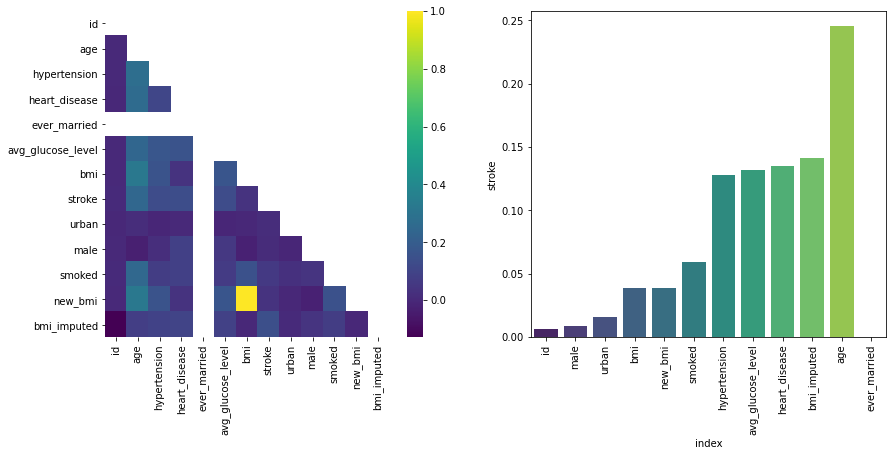

In [77]:
def heatmapper(data, method, target_col, annot=False, normality=False):
    # create a correlation matrix
    correlation_df = data.corr(method=method)
    correlation_mask = np.triu(np.ones_like(correlation_df))
    
    # create the data for the bar plot
    bar_df = correlation_df[target_col]
    bar_df = bar_df[bar_df.index != target_col].sort_values(ascending=True).reset_index()
    
    # plot the heat map 
    if normality:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    else: 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(data=correlation_df, mask=correlation_mask, annot=annot, cmap='viridis', ax=ax1)
    
    # plot the bar graph
    sns.barplot(x='index', y='stroke', data=bar_df, palette='viridis', ax=ax2)
    ax2.set_xticklabels(bar_df['index'], rotation=90)
    
    if normality:
    # check if the feature is guassian
        probability=0.05

        _, p = shapiro(data[target_col])
        qqplot(data[target_col], line='s', ax=ax3)
        if p > probability:
            ax3.set_title(f'P value of {p} > {probability} -> Gaussian')
        else:
            ax3.set_title(f'P value of {p} <= {probability} -> Not gaussian')
    else:
        pass

    return plt.show()



heatmapper(data, 'pearson', 'stroke')

In [93]:
def convert_binary_features(data):
    # convert the binary fields into 1/0
    data['ever_married'] = np.where(data['ever_married'] == 'Yes', 1, 0)
    data['urban'] = np.where(data['Residence_type'] == 'Urban', 1, 0)
    data['male'] = np.where(data['gender'] == 'Male', 1, 0)
    
    # Convert if ever smoked into a binary field
    smoking_list = ['formerly smoked', 'smokes']
    data['smoked'] = np.where(data['smoking_status'].isin(smoking_list), 1, 0)
    
    # BMI is the only null column, for now try imputing the mean value
    median_bmi = data['bmi'].median()
    mean_bmi = data['bmi'].mean()
    data['new_bmi'] = np.where(data['bmi'].isnull(), mean_bmi, data['bmi'])
    data['bmi_imputed'] = np.where(data['bmi'].isnull(), 1, 0)

    # get dummies for work features
    work_dummies = pd.get_dummies(data['work_type'], drop_first=True, prefix='work')
    data = pd.merge(left=data,
                    right=work_dummies,
                    how='left',
                    left_index=True,
                    right_index=True)
    
    
    # standardise glucose and BMI
    data['glucose'] = (data['avg_glucose_level'] - data['avg_glucose_level'].mean()) / data['avg_glucose_level'].std()
    data['body_mass_index'] = (data['new_bmi'] - data['new_bmi'].mean()) / data['new_bmi'].std()
    data['age'] = np.log(data['age'])
    
    # if you have a glucose level over 200 you are v likley to be diabetic - increasing your rish
    data['diabetes'] = np.where(data['avg_glucose_level'] > 200, 1, 0)
    
    # remove old columns from dataset
    drop_cols = ['Residence_type', 'gender', 'bmi', 'work_type', 'smoking_status', 
                'new_bmi', 'avg_glucose_level', 'id']
    data = data.drop(drop_cols, axis=1)
    return data


df = convert_binary_features(data)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,urban,male,smoked,new_bmi,bmi_imputed
0,9046,Male,67.0,0,1,0,Private,Urban,228.69,36.600000,formerly smoked,1,1,1,1,36.600000,0
1,51676,Female,61.0,0,0,0,Self-employed,Rural,202.21,28.893237,never smoked,1,0,0,0,28.893237,0
2,31112,Male,80.0,0,1,0,Private,Rural,105.92,32.500000,never smoked,1,0,1,0,32.500000,0
3,60182,Female,49.0,0,0,0,Private,Urban,171.23,34.400000,smokes,1,1,0,1,34.400000,0
4,1665,Female,79.0,1,0,0,Self-employed,Rural,174.12,24.000000,never smoked,1,0,0,0,24.000000,0


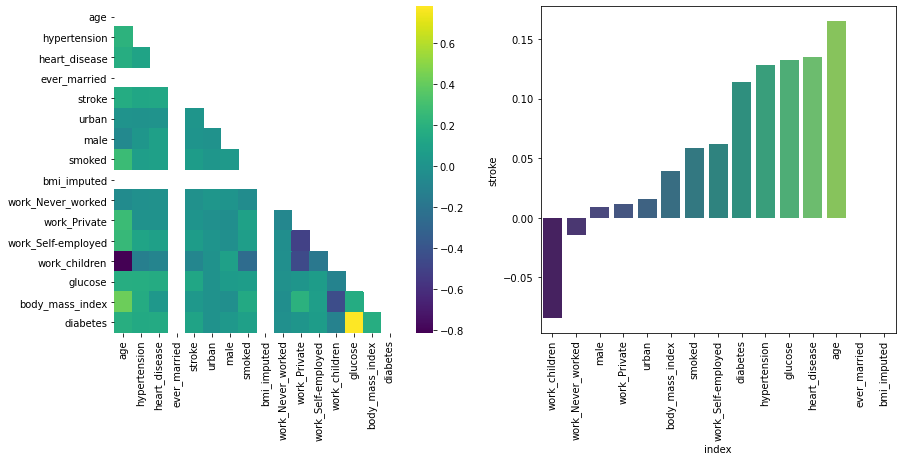

In [146]:
heatmapper(df, 'pearson', 'stroke', annot=False)

In [147]:
data['bmi'].value_counts()

28.893237    201
28.700000     41
28.400000     38
26.700000     37
26.100000     37
            ... 
48.000000      1
49.400000      1
47.400000      1
46.600000      1
54.000000      1
Name: bmi, Length: 419, dtype: int64

In [148]:
data['bmi'].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [149]:
data['bmi'].fillna(data['bmi'].mean(),inplace=True)

In [150]:
data['bmi'].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [151]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
urban                0
male                 0
smoked               0
new_bmi              0
bmi_imputed          0
dtype: int64

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int32  
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
 11  urban              5110 non-null   int32  
 12  male               5110 non-null   int32  
 13  smoked             5110 non-null   int32  
 14  new_bmi            5110 non-null   float64
 15  bmi_imputed        5110 non-null   int32  
dtypes: float64(4), int32(5),

In [167]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,urban,male,smoked,new_bmi,bmi_imputed
0,Male,67.0,0,1,0,Private,Urban,228.69,36.600000,formerly smoked,1,1,1,1,36.600000,0
1,Female,61.0,0,0,0,Self-employed,Rural,202.21,28.893237,never smoked,1,0,0,0,28.893237,0
2,Male,80.0,0,1,0,Private,Rural,105.92,32.500000,never smoked,1,0,1,0,32.500000,0
3,Female,49.0,0,0,0,Private,Urban,171.23,34.400000,smokes,1,1,0,1,34.400000,0
4,Female,79.0,1,0,0,Self-employed,Rural,174.12,24.000000,never smoked,1,0,0,0,24.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,0,Private,Urban,83.75,28.893237,never smoked,0,1,0,0,28.893237,0
5106,Female,81.0,0,0,0,Self-employed,Urban,125.20,40.000000,never smoked,0,1,0,0,40.000000,0
5107,Female,35.0,0,0,0,Self-employed,Rural,82.99,30.600000,never smoked,0,0,0,0,30.600000,0
5108,Male,51.0,0,0,0,Private,Rural,166.29,25.600000,formerly smoked,0,0,1,1,25.600000,0


# Outlier Removation

In [174]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=800, facecolor='w', edgecolor='k')

<Figure size 6400x4800 with 0 Axes>

<Figure size 6400x4800 with 0 Axes>

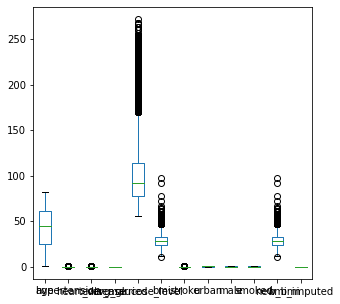

In [178]:
data.plot(kind='box')
plt.show()

# Label Encoding

In [181]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,urban,male,smoked,new_bmi,bmi_imputed
0,Male,67.0,0,1,0,Private,Urban,228.69,36.600000,formerly smoked,1,1,1,1,36.600000,0
1,Female,61.0,0,0,0,Self-employed,Rural,202.21,28.893237,never smoked,1,0,0,0,28.893237,0
2,Male,80.0,0,1,0,Private,Rural,105.92,32.500000,never smoked,1,0,1,0,32.500000,0
3,Female,49.0,0,0,0,Private,Urban,171.23,34.400000,smokes,1,1,0,1,34.400000,0
4,Female,79.0,1,0,0,Self-employed,Rural,174.12,24.000000,never smoked,1,0,0,0,24.000000,0


In [185]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()

In [192]:
gender=enc.fit_transform(data['gender'])

In [198]:
smoking_status=enc.fit_transform(data['smoking_status'])

In [204]:
work_type=enc.fit_transform(data['work_type'])
Residence_type=enc.fit_transform(data['Residence_type'])
ever_married=enc.fit_transform(data['ever_married'])

In [207]:
data['work_type']=work_type

In [212]:
data['ever_married']=ever_married
data['Residence_type']=Residence_type
data['smoking_status']=smoking_status
data['gender']=gender

In [218]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,urban,male,smoked,new_bmi,bmi_imputed
0,1,67.0,0,1,0,2,1,228.69,36.600000,1,1,1,1,1,36.600000,0
1,0,61.0,0,0,0,3,0,202.21,28.893237,2,1,0,0,0,28.893237,0
2,1,80.0,0,1,0,2,0,105.92,32.500000,2,1,0,1,0,32.500000,0
3,0,49.0,0,0,0,2,1,171.23,34.400000,3,1,1,0,1,34.400000,0
4,0,79.0,1,0,0,3,0,174.12,24.000000,2,1,0,0,0,24.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,0,2,1,83.75,28.893237,2,0,1,0,0,28.893237,0
5106,0,81.0,0,0,0,3,1,125.20,40.000000,2,0,1,0,0,40.000000,0
5107,0,35.0,0,0,0,3,0,82.99,30.600000,2,0,0,0,0,30.600000,0
5108,1,51.0,0,0,0,2,0,166.29,25.600000,1,0,0,1,1,25.600000,0


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int32  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int32  
 6   Residence_type     5110 non-null   int32  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   int32  
 10  stroke             5110 non-null   int64  
 11  urban              5110 non-null   int32  
 12  male               5110 non-null   int32  
 13  smoked             5110 non-null   int32  
 14  new_bmi            5110 non-null   float64
 15  bmi_imputed        5110 non-null   int32  
dtypes: float64(4), int32(8),

# Splitting the data for train and test

X ---train_X,test_X  80/20                   
Y ---train_Y,test_Y

In [231]:
X=data.drop('stroke',axis=1)

In [238]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,urban,male,smoked,new_bmi,bmi_imputed
0,1,67.0,0,1,0,2,1,228.69,36.600000,1,1,1,1,36.600000,0
1,0,61.0,0,0,0,3,0,202.21,28.893237,2,0,0,0,28.893237,0
2,1,80.0,0,1,0,2,0,105.92,32.500000,2,0,1,0,32.500000,0
3,0,49.0,0,0,0,2,1,171.23,34.400000,3,1,0,1,34.400000,0
4,0,79.0,1,0,0,3,0,174.12,24.000000,2,0,0,0,24.000000,0


In [243]:
Y=data['stroke']

In [244]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [245]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

In [250]:
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,urban,male,smoked,new_bmi,bmi_imputed
2285,1,49.0,0,0,0,2,0,79.64,28.893237,3,0,1,1,28.893237,0
4733,1,67.0,0,0,0,2,0,83.16,25.500000,1,0,1,1,25.500000,0
3905,1,78.0,0,0,0,2,1,208.85,24.400000,1,1,1,1,24.400000,0
4700,1,47.0,0,0,0,2,0,110.14,30.500000,3,0,1,1,30.500000,0
4939,0,59.0,0,0,0,2,1,71.08,28.100000,2,1,0,0,28.100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,0,62.0,0,0,0,2,0,82.57,36.000000,1,0,0,1,36.000000,0
3441,0,59.0,0,0,0,3,1,90.06,28.900000,3,1,0,1,28.900000,0
1344,1,47.0,0,0,0,2,0,86.37,39.200000,3,0,1,1,39.200000,0
4623,1,25.0,0,0,0,0,1,166.38,23.100000,2,1,1,0,23.100000,0


In [256]:
Y_train

2285    0
4733    0
3905    0
4700    0
4939    0
       ..
1180    0
3441    0
1344    0
4623    0
1289    0
Name: stroke, Length: 4088, dtype: int64

In [259]:
X_test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,urban,male,smoked,new_bmi,bmi_imputed
2413,0,58.00,0,0,0,2,0,100.42,39.500000,3,0,0,1,39.500000,0
1141,1,57.00,0,0,0,2,0,90.06,29.800000,0,0,1,0,29.800000,0
146,1,65.00,0,0,0,3,1,68.43,28.893237,1,1,1,1,28.893237,0
3883,0,1.64,0,0,0,4,1,69.89,18.100000,0,1,0,0,18.100000,0
1044,0,79.00,0,0,0,0,1,93.89,30.400000,2,1,0,0,30.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,1,59.00,0,0,0,2,1,60.35,25.900000,1,1,1,1,25.900000,0
4712,1,57.00,0,0,0,2,1,93.04,29.200000,2,1,1,0,29.200000,0
4971,0,63.00,0,0,0,2,1,57.06,37.900000,2,1,0,0,37.900000,0
2224,1,57.00,0,0,0,2,0,76.28,31.400000,1,0,1,1,31.400000,0


In [262]:
Y_test

2413    0
1141    0
146     1
3883    0
1044    0
       ..
2261    0
4712    0
4971    0
2224    0
4825    0
Name: stroke, Length: 1022, dtype: int64

# Normalize

In [267]:
data.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,urban,male,smoked,new_bmi,bmi_imputed
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.0,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.0
mean,0.414286,43.226614,0.097456,0.054012,0.0,2.167710,0.508023,106.147677,28.893237,1.376908,0.048728,0.508023,0.413894,0.327593,28.893237,0.0
std,0.493044,22.612647,0.296607,0.226063,0.0,1.090293,0.499985,45.283560,7.698018,1.071534,0.215320,0.499985,0.492578,0.469381,7.698018,0.0
min,0.000000,0.080000,0.000000,0.000000,0.0,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000,10.300000,0.0
25%,0.000000,25.000000,0.000000,0.000000,0.0,2.000000,0.000000,77.245000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,23.800000,0.0
50%,0.000000,45.000000,0.000000,0.000000,0.0,2.000000,1.000000,91.885000,28.400000,2.000000,0.000000,1.000000,0.000000,0.000000,28.400000,0.0
75%,1.000000,61.000000,0.000000,0.000000,0.0,3.000000,1.000000,114.090000,32.800000,2.000000,0.000000,1.000000,1.000000,1.000000,32.800000,0.0
max,2.000000,82.000000,1.000000,1.000000,0.0,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000,1.000000,1.000000,1.000000,97.600000,0.0


In [273]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()

In [278]:
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)

# lets save the scaler object

In [281]:
import pickle
import os


In [284]:
X_train_std

array([[ 1.19359699,  0.2521852 , -0.33069968, ...,  1.42570718,
         0.00238781,  0.        ],
       [ 1.19359699,  1.04686385, -0.33069968, ...,  1.42570718,
        -0.44065504,  0.        ],
       [ 1.19359699,  1.5325008 , -0.33069968, ...,  1.42570718,
        -0.58427812,  0.        ],
       ...,
       [ 1.19359699,  0.16388757, -0.33069968, ...,  1.42570718,
         1.34810513,  0.        ],
       [ 1.19359699, -0.80738634, -0.33069968, ..., -0.7014063 ,
        -0.75401449,  0.        ],
       [-0.83780372,  1.62079843, -0.33069968, ..., -0.7014063 ,
        -0.16646553,  0.        ]])

In [288]:
X_test_std

array([[-0.83780372,  0.64952452, -0.33069968, ...,  1.42570718,
         1.38727506,  0.        ],
       [ 1.19359699,  0.60537571, -0.33069968, ..., -0.7014063 ,
         0.12078063,  0.        ],
       [ 1.19359699,  0.95856622, -0.33069968, ...,  1.42570718,
         0.00238781,  0.        ],
       ...,
       [-0.83780372,  0.87026859, -0.33069968, ..., -0.7014063 ,
         1.17836876,  0.        ],
       [ 1.19359699,  0.60537571, -0.33069968, ...,  1.42570718,
         0.32968693,  0.        ],
       [-0.83780372, -1.29302329, -0.33069968, ..., -0.7014063 ,
        -1.31545016,  0.        ]])

# Decision Tree

In [293]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

In [301]:
dt.fit(X_train_std,Y_train)

DecisionTreeClassifier()

In [309]:
dt.feature_importances_

array([0.0214669 , 0.17059545, 0.02118856, 0.01969695, 0.        ,
       0.05473948, 0.0383308 , 0.3041527 , 0.14822382, 0.04829971,
       0.01124848, 0.01315864, 0.01372116, 0.13517734, 0.        ])

In [315]:
X_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'urban', 'male', 'smoked', 'new_bmi', 'bmi_imputed'],
      dtype='object')

In [321]:
Y_pred=dt.predict(X_test_std)

In [327]:
Y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [334]:
from sklearn.metrics import accuracy_score

In [340]:
ac_dt=accuracy_score(Y_test,Y_pred)

In [347]:
ac_dt

0.9050880626223092

# Logistic Regression

In [356]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [357]:
lr.fit(X_train_std,Y_train)

LogisticRegression()

In [358]:
Y_pred_lr=lr.predict(X_test_std)

In [359]:
Y_pred_lr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [360]:
ac_lr=accuracy_score(Y_test,Y_pred_lr)

In [361]:
ac_lr

0.9393346379647749

# KNN

In [483]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()

In [484]:
knn.fit(X_train_std,Y_train)

KNeighborsClassifier()

In [485]:
Y_pred=knn.predict(X_test_std)

In [486]:
ac_knn=accuracy_score(Y_test,Y_pred)

In [487]:
ac_knn

0.9344422700587084